In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stt
from sklearn.decomposition import PCA

In [45]:
DATA_DIR = '../../datasets/NNN/face_roi_data.pkl'
dat = pd.read_pickle(DATA_DIR)

print(f'Unique face ROIs: {list(dat['monkey'].unique())}')

Unique face ROIs: [np.int64(3), np.int64(1)]


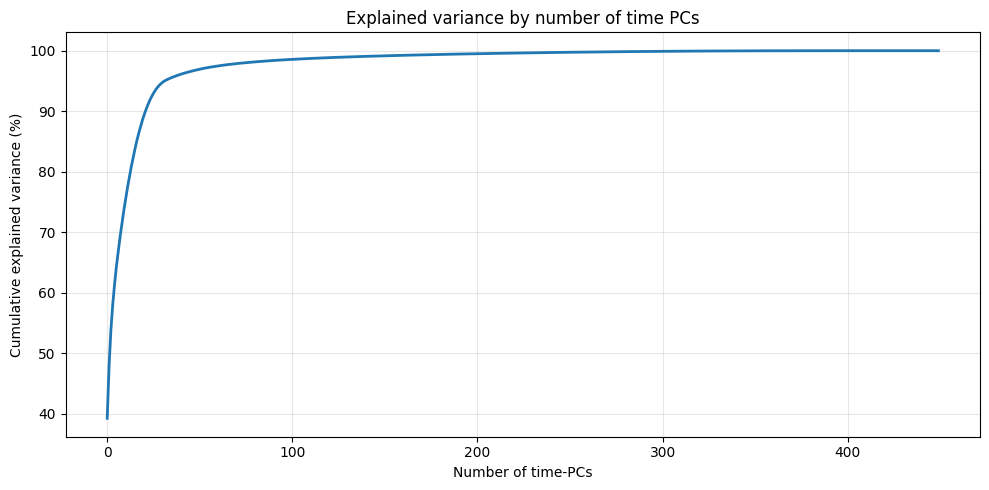

In [43]:
ROI = 'MF1_7_F'
roi_dat = dat[(dat['roi']==ROI) & (dat['p_value']<0.05)].reset_index(drop=True)
X = np.stack(roi_dat['img_psth'])
# X = X[:, :, 1000:]
# X = stt.zscore(X, axis=1)
# X = np.nan_to_num(X)

# Find patterns shared across *time points*
U, T, I = X.shape
Y = X.transpose(0, 2, 1).reshape(U * I, T)          # (samples=unit×image, features=time)
Yc = Y - Y.mean(axis=0, keepdims=True)              # center across time features

pca = PCA().fit(Yc)

plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_) * 100, linewidth=2)
plt.xlabel("Number of time-PCs"); plt.ylabel("Cumulative explained variance (%)")
plt.title("Explained variance by number of time PCs"); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

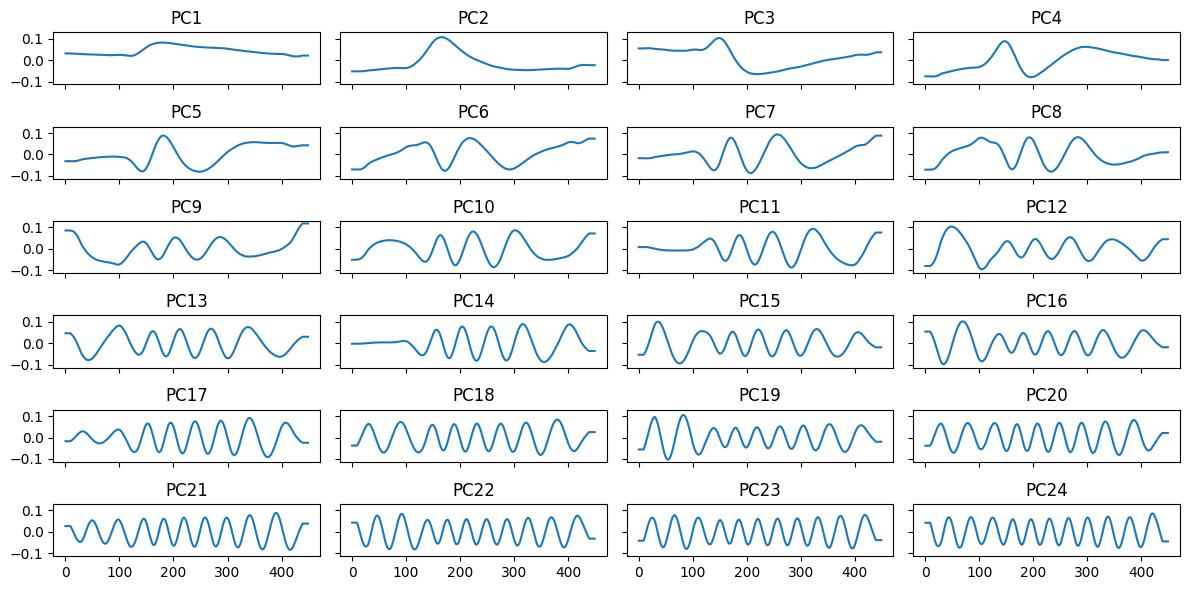

In [44]:
k = 24
C = pca.components_[:k]          # (k, T)
fig, axes = plt.subplots(6, 4, figsize=(12, 6), sharex=True, sharey=True)
axes = axes.ravel()
for i in range(k):
    axes[i].plot(C[i])
    axes[i].set_title(f"PC{i+1}")
plt.tight_layout(); plt.show()